## Exercise 1

Poisson regression is a Generalized Linear Model, used to model count data. It takes the form

$$\mathbb{E}(\mu|x)=\exp(w_1\,x_1+\ldots+w_k\,x_k+b),$$

where the observed counts $y$ are drawn from a Poisson distribution on the expected counts: 

$$y_i \sim \text{Poisson}(\mu_i).$$

1. Download and import Load the smoking dataset from: [https://data.princeton.edu/wws509/datasets/#smoking](https://data.princeton.edu/wws509/datasets/#smoking). Then perform a train-test split on the data;
2. Fit a Poisson bayesian regression model using the number of deaths as the response variable and the other columns as the explanatory variables;
3. Evaluate the regression fit on test data using MAE and MSE error metrics.

In [1]:
import pyro
import torch
import pyro.distributions as dist
import pyro.optim as optim
from pyro.infer import SVI, Trace_ELBO
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pyro.infer import Predictive
import torch.distributions.constraints as constraints
import copy
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
figsize = (10, 4)
pyro.set_rng_seed(42)

smoking_data = pd.read_csv("https://data.princeton.edu/wws509/datasets/smoking.dat", sep='\s+')
smoking_data.info()
# convert categorical variables into dummies variables
smoking_data = pd.get_dummies(smoking_data)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36 entries, 1 to 36
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   age     36 non-null     object
 1   smoke   36 non-null     object
 2   pop     36 non-null     int64 
 3   dead    36 non-null     int64 
dtypes: int64(2), object(2)
memory usage: 1.4+ KB


In [2]:
# re-scale the populatiopn dependent variable as it is too dominant compared to
# the other ones
smoking_data["pop"] = MinMaxScaler().fit_transform(pd.DataFrame(smoking_data["pop"]))

Now we apply the train-test split with 0.8 threshold

In [3]:
num_deaths = torch.tensor(smoking_data["dead"].values, dtype=torch.float)
predictors = torch.stack([torch.tensor(smoking_data[column].values, dtype=torch.float)
                         for column in smoking_data.columns if column != "dead"], 1)


X_train, X_test, y_train, y_test = train_test_split(predictors, num_deaths, test_size=0.20, 
                                                    random_state=54, shuffle=True)

In [4]:
def death_model(predictors, deaths):
    n_observations, n_predictors=predictors.shape
    w=pyro.sample("w", dist.Normal(torch.zeros(n_predictors),
                                   torch.ones(n_predictors)))
    b=pyro.sample("b", dist.LogNormal(torch.zeros(1), torch.ones(1)))

    mu_hat=torch.exp((w*predictors).sum(dim=1) + b)

    with pyro.plate("dead", len(deaths)):
        pyro.sample("obs", dist.Poisson(mu_hat), obs = deaths)


def death_guide(predictors, deaths=None):
    n_observations, n_predictors = predictors.shape

    w_loc = pyro.param("w_loc", torch.rand(n_predictors),
                       constraint=constraints.positive)
    w_scale = pyro.param("w_scale", torch.rand(n_predictors), 
                         constraint=constraints.positive)

    w = pyro.sample("w", dist.Gamma(w_loc, w_scale))

    b_loc = pyro.param("b_loc", torch.rand(1))
    b_scale = pyro.param("b_scale", torch.rand(1), constraint=constraints.positive)

    b = pyro.sample("b", dist.LogNormal(b_loc, b_scale))

In [5]:
pyro.clear_param_store()

death_svi = SVI(model=death_model, guide=death_guide, 
                optim=optim.ClippedAdam({'lr' : 0.01}), 
                loss=Trace_ELBO())

for step in range(2000):
    loss = death_svi.step(X_train, y_train)/len(X_train)
    if step % 100 == 0:
        print(f"Step {step} : loss = {loss}")

Step 0 : loss = 340.44569380368506
Step 100 : loss = 614.3885453747852
Step 200 : loss = 74407678553.82405
Step 300 : loss = 2192.20110148085
Step 400 : loss = 2941.399439598833
Step 500 : loss = 47593187.10402433
Step 600 : loss = 28314.142829375607
Step 700 : loss = 2.9697890744236396e+18
Step 800 : loss = 275488981085662.47
Step 900 : loss = 5921509981.112805
Step 1000 : loss = 3558.9095321212494
Step 1100 : loss = 131537.857019169
Step 1200 : loss = 5967.514833586557
Step 1300 : loss = 984449042.5697508
Step 1400 : loss = 51144350.05826286
Step 1500 : loss = 194488.94051759582
Step 1600 : loss = 3473950.5250530923
Step 1700 : loss = 102424164084.47119
Step 1800 : loss = 1296.5548257146563
Step 1900 : loss = 117722.92156015124


In [6]:
print("Inferred params:", list(pyro.get_param_store().keys()), end="\n\n")
# w_i and b posterior mean
inferred_w = pyro.get_param_store()["w_loc"]
inferred_b = pyro.get_param_store()["b_loc"]


for i,w in enumerate(inferred_w):
    print(f"w_{i} = {w.item():.8f}")
print(f"b = {inferred_b.item():.8f}")

Inferred params: ['w_loc', 'w_scale', 'b_loc', 'b_scale']

w_0 = 0.08529035
w_1 = 1.50175571
w_2 = 1.40396845
w_3 = 1.09975612
w_4 = 0.70939481
w_5 = 1.27312958
w_6 = 1.58847809
w_7 = 2.25620604
w_8 = 1.18238509
w_9 = 1.92340398
w_10 = 0.09508379
w_11 = 0.09032905
w_12 = 0.07013020
w_13 = 0.06724532
b = -12.77771473


In [7]:
# print latent params quantile information
def summary(samples):
    stats = {}
    for par_name, values in samples.items():
        marginal = pd.DataFrame(values)
        percentiles=[.05, 0.5, 0.95]
        describe = marginal.describe(percentiles).transpose()
        stats[par_name] = describe[["mean", "std", "5%", "50%", "95%"]]
    return stats

# define the posterior predictive
predictive = Predictive(model=death_model, guide=death_guide, num_samples=100,
                        return_sites=("w","b"))

# get posterior samples on test data
svi_samples = {k: v.detach().numpy() for k, v in predictive(X_test, y_test).items()}

# show summary statistics
for key, value in summary(svi_samples).items():
    print(f"Sampled parameter = {key}\n\n{value}\n")

Sampled parameter = w

        mean       std            5%           50%        95%
0   0.000030  0.000100  5.249011e-17  2.901223e-07   0.000142
1   4.107063  3.559332  3.947709e-01  3.387483e+00  10.122283
2   3.018390  2.333618  2.637116e-01  2.453260e+00   7.201630
3   7.712648  7.560554  3.822936e-01  5.589813e+00  21.962329
4   7.500891  8.890011  1.332020e-01  5.213586e+00  26.505133
5   8.095703  7.247715  6.199368e-01  5.695526e+00  23.552204
6   6.953088  5.507989  1.078475e+00  5.541534e+00  18.180219
7   6.742757  4.093624  2.435832e+00  5.591381e+00  15.887255
8   7.577703  6.450333  6.837420e-01  5.780329e+00  20.106481
9   6.012335  3.991174  1.140936e+00  5.268776e+00  14.147942
10  0.000041  0.000125  2.409273e-15  1.882390e-07   0.000253
11  0.000045  0.000137  1.256541e-18  8.671273e-08   0.000282
12  0.000012  0.000043  1.226966e-21  2.297895e-09   0.000055
13  0.000036  0.000130  1.014594e-24  6.083629e-08   0.000212

Sampled parameter = b

       mean       std  

In [8]:
# compute predictions using the inferred paramters
y_pred = torch.exp((inferred_w * X_test).sum(dim=1) + inferred_b)
print("MAE =", torch.nn.L1Loss()(y_test, y_pred).item())
print("MSE =", torch.nn.MSELoss()(y_test, y_pred).item())

MAE = 259.625
MSE = 167747.625


Now we try with Pyro's autoguide utility and see if we can get better results

In [9]:
pyro.clear_param_store()
death_guide = pyro.infer.autoguide.AutoMultivariateNormal(death_model)
death_svi = SVI(model=death_model, guide=death_guide, 
                optim=optim.ClippedAdam({'lr' : 0.01}), 
                loss=Trace_ELBO())

for step in range(2000):
    loss = death_svi.step(X_train, y_train)/len(X_train)
    if step % 100 == 0:
        print(f"Step {step} : loss = {loss}")

Step 0 : loss = 942.9904812797904
Step 100 : loss = 66.99677536743027
Step 200 : loss = 111.00122942243304
Step 300 : loss = 15.633145809173584
Step 400 : loss = 20.819027342966624
Step 500 : loss = 13.05750555225781
Step 600 : loss = 13.329340875148773
Step 700 : loss = 20.64639809301921
Step 800 : loss = 38.18989856328283
Step 900 : loss = 36.56496188470295
Step 1000 : loss = 53.958951907498495
Step 1100 : loss = 15.517508089542389
Step 1200 : loss = 14.35986950142043
Step 1300 : loss = 29.11458254499095
Step 1400 : loss = 57.209870031901765
Step 1500 : loss = 58.77983671001026
Step 1600 : loss = 25.565964498690196
Step 1700 : loss = 69.97152726990836
Step 1800 : loss = 15.42809426358768
Step 1900 : loss = 26.244639249784605


In [10]:
print("Inferred params:", list(pyro.get_param_store().keys()), end="\n\n")
# w_i and b posterior mean
inferred_w = pyro.get_param_store()["AutoMultivariateNormal.loc"][:-1]
inferred_b = pyro.get_param_store()["AutoMultivariateNormal.loc"][-1]
#inferred_b = pyro.get_param_store()["AutoMultivariateNormal.scale_tril"]
#print(inferred_b.shape)
for i,w in enumerate(inferred_w):
    print(f"w_{i} = {w.item():.8f}")
print(f"b = {inferred_b.item():.8f}")

Inferred params: ['AutoMultivariateNormal.loc', 'AutoMultivariateNormal.scale_tril']

w_0 = 2.08941865
w_1 = -0.66576290
w_2 = -0.97198164
w_3 = 0.31020376
w_4 = 0.71414906
w_5 = 1.12342572
w_6 = 1.47310507
w_7 = 1.55620039
w_8 = 1.41532421
w_9 = 1.44062579
w_10 = 0.70266092
w_11 = 1.27092719
w_12 = 1.17221582
w_13 = 0.38862407
b = 1.06182897


In [11]:
# print latent params quantile information
def summary(samples):
    stats = {}
    for par_name, values in samples.items():
        marginal = pd.DataFrame(values)
        percentiles=[.05, 0.5, 0.95]
        describe = marginal.describe(percentiles).transpose()
        stats[par_name] = describe[["mean", "std", "5%", "50%", "95%"]]
    return stats

# define the posterior predictive
predictive = Predictive(model=death_model, guide=death_guide, num_samples=100,
                        return_sites=("w","b"))

# get posterior samples on test data
svi_samples = {k: v.detach().numpy() for k, v in predictive(X_test, y_test).items()}

# show summary statistics
for key, value in summary(svi_samples).items():
    print(f"Sampled parameter = {key}\n\n{value}\n")

Sampled parameter = w

        mean       std        5%       50%       95%
0   2.110069  0.155926  1.832691  2.115758  2.329601
1  -0.673300  0.091323 -0.830977 -0.674030 -0.524364
2  -0.948740  0.284046 -1.456833 -0.934367 -0.467945
3   0.314714  0.136072  0.108771  0.299383  0.558504
4   0.714192  0.193139  0.414354  0.714178  1.057482
5   1.120094  0.256846  0.744823  1.103222  1.597754
6   1.471822  0.195263  1.129089  1.459940  1.798666
7   1.556424  0.256907  1.168411  1.498783  1.995960
8   1.420445  0.197033  1.110182  1.411551  1.713331
9   1.421435  0.244658  1.014127  1.410742  1.812998
10  0.731125  0.396433  0.068294  0.748195  1.392736
11  1.288815  0.419294  0.580862  1.329746  1.922375
12  1.175888  0.450533  0.349517  1.227538  1.882553
13  0.408145  0.424560 -0.275476  0.465078  1.014390

Sampled parameter = b

      mean       std        5%       50%       95%
0  2.93648  0.590585  2.045619  2.902178  3.846368



In [12]:
# compute predictions using the inferred paramters
y_pred = torch.exp((inferred_w * X_test).sum(dim=1) + inferred_b)
print("MAE =", torch.nn.L1Loss()(y_test, y_pred).item())
print("MSE =", torch.nn.MSELoss()(y_test, y_pred).item())

MAE = 210.6351318359375
MSE = 106670.9453125


The results are slightly better by using the autoguide

## Exercise 2

The Iris dataset contains petal and sepal length and width for three different types of Iris flowers: Setosa, Versicolour, and Virginica.

1. Import the Iris dataset from `sklearn`:
```
from sklearn import datasets
iris = datasets.load_iris()
```
and perform a train-test split on the data.

2. Fit a multinomial bayesian logistic regression model on the four predictors petal length/width and sepal length/width. 

3. Evaluate your bayesian classifier on test data: compute the overall test accuracy and class-wise accuracy for the three different flower categories.

In [1]:
%reset -f
import pyro
import torch
import pyro.distributions as dist
import pyro.optim as optim
from pyro.infer import SVI, Trace_ELBO
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pyro.infer import Predictive
import torch.distributions.constraints as constraints
import copy
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
figsize = (10, 4)
pyro.set_rng_seed(42)
from sklearn import datasets


iris = datasets.load_iris()
iris.data = (iris.data - np.min(iris.data))/(np.max(iris.data)-np.min(iris.data))
#iris

In [2]:
iris_predictors = torch.tensor(iris.data, dtype=torch.float)
iris_species = torch.tensor(iris.target, dtype=torch.float)
X_train, X_test, y_train, y_test = train_test_split(iris_predictors, iris_species, test_size=0.20, 
                                                    random_state=42, shuffle=True)

Step 0 : loss = 1.0715216889977455
Step 1000 : loss = 1.0455803647637367
Step 2000 : loss = 1.0452774614095688
Step 3000 : loss = 1.0484627356131873
Step 4000 : loss = 1.0580982054273287
Step 5000 : loss = 1.0209322586655616
Step 6000 : loss = 0.9680095300078392
Step 7000 : loss = 1.0578199371695518
Step 8000 : loss = 0.9616574068864187
Step 9000 : loss = 0.9644003167748452


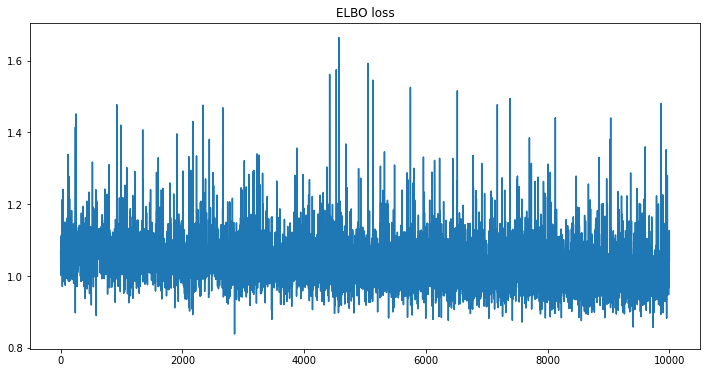

In [8]:

# model and guide functions
def log_reg_model(x, y):
    n_observations, n_predictors = x.shape
    W = [pyro.sample("w_"+str(i), dist.Normal(torch.zeros(n_predictors), torch.ones(n_predictors)))
         for i in range(0, 3)]
    B = [pyro.sample("b_"+str(i), dist.Normal(0., 1.))
         for i in range(0, 3)]
    
    yhat = torch.stack(
        [torch.sigmoid((W[i]*x).sum(dim=1) + B[i])
         for i in range(0, 3)],
        dim=1
    )
    with pyro.plate("data", n_observations):
        # sampling 0-1 labels from Bernoulli distribution
        y = pyro.sample("y", dist.Categorical(yhat), obs=y)
               
def log_reg_guide(x, y=None):
    
    n_observations, n_predictors = x.shape
    
    w_loc_zero = pyro.param("w_loc_zero", torch.rand(n_predictors))
    w_scale_zero = pyro.param("w_scale_zero", torch.rand(n_predictors), constraint=constraints.positive)
    w_zero = pyro.sample("w_0", dist.Laplace(w_loc_zero, w_scale_zero))
    
    b_loc_zero = pyro.param("b_loc_zero", torch.rand(1))
    b_scale_zero = pyro.param("b_scale_zero", torch.rand(1), constraint=constraints.positive)
    b_zero = pyro.sample("b_0", dist.Normal(b_loc_zero, b_scale_zero))
    
    w_loc_one = pyro.param("w_loc_one", torch.rand(n_predictors))
    w_scale_one = pyro.param("w_scale_one", torch.rand(n_predictors), constraint=constraints.positive)
    w_one = pyro.sample("w_1", dist.Laplace(w_loc_one, w_scale_one))
    
    b_loc_one = pyro.param("b_loc_one", torch.rand(1))
    b_scale_one = pyro.param("b_scale_one", torch.rand(1), constraint=constraints.positive)
    b_one = pyro.sample("b_1", dist.Normal(b_loc_one, b_scale_one))
    
    w_loc_two = pyro.param("w_loc_two", torch.rand(n_predictors))
    w_scale_two = pyro.param("w_scale_two", torch.rand(n_predictors), constraint=constraints.positive)
    w_two = pyro.sample("w_2", dist.Laplace(w_loc_two, w_scale_two))
    
    b_loc_two = pyro.param("b_loc_two", torch.rand(1))
    b_scale_two = pyro.param("b_scale_two", torch.rand(1), constraint=constraints.positive)
    b_two = pyro.sample("b_2", dist.Normal(b_loc_two, b_scale_two))



log_reg_svi = SVI(model=log_reg_model, guide=log_reg_guide, 
          optim=optim.ClippedAdam({'lr' : 0.0002}), 
          loss=Trace_ELBO()) 

losses = []
for step in range(10000):
    loss = log_reg_svi.step(X_train, y_train)/len(X_train)
    losses.append(loss)
    if step % 1000 == 0:
        print(f"Step {step} : loss = {loss}")
        
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(losses)
ax.set_title("ELBO loss");

Step 0 : loss = 0.9765208333730697
Step 1000 : loss = 0.966140120724837
Step 2000 : loss = 0.9586402614911397
Step 3000 : loss = 0.9526994576056799
Step 4000 : loss = 0.9478651449084282
Step 5000 : loss = 0.943986660738786
Step 6000 : loss = 0.9409688303867976
Step 7000 : loss = 0.938714991013209
Step 8000 : loss = 0.9371061012148857
Step 9000 : loss = 0.9360012566049893


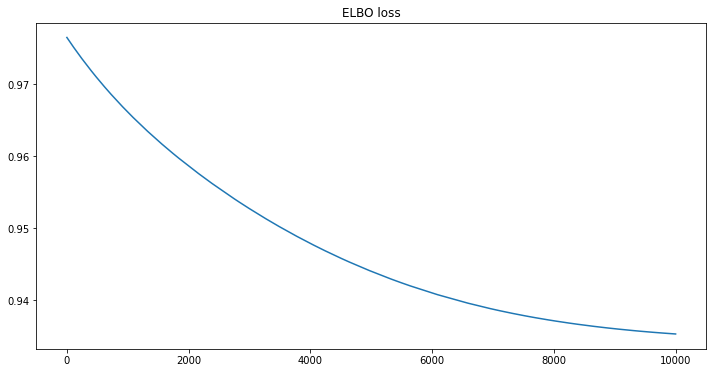

In [9]:
auto_guide = pyro.infer.autoguide.AutoDelta(log_reg_model)
log_reg_svi = SVI(model=log_reg_model, guide=auto_guide, 
          optim=optim.ClippedAdam({'lr' : 0.0002}), 
          loss=Trace_ELBO()) 

losses = []
for step in range(10000):
    loss = log_reg_svi.step(X_train, y_train)/len(X_train)
    losses.append(loss)
    if step % 1000 == 0:
        print(f"Step {step} : loss = {loss}")
        
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(losses)
ax.set_title("ELBO loss");

Looks like that the ELBO loss is lower with the autoguide AutoDelta, we will keep the results and valide the model.

In [14]:
import re
params_store = pyro.get_param_store()
pattern_w = re.compile('w_loc_*')
pattern_b = re.compile('b_loc_*')
#get the loc values according to the string patterns defined above
W = [params_store[key] for key in params_store.keys() if pattern_w.match(key)]
B = [params_store[key] for key in params_store.keys() if pattern_b.match(key)]

# this function returns the class that achievied the maximum probability 
# over the others
def predict_class(predictors, param_W, param_B):
    result = torch.stack(
        [torch.sigmoid((W[i] * predictors).sum(dim=1) + B[i])
         for i in range(0, len(W))],
        dim=1
    )
    return torch.argmax(result, dim=1)

predictions = predict_class(X_test, W, B)
predictions_vs_real = list(zip(predictions , y_test))

def class_checker(class_label):
    def func(predicted_vs_real):
        return predicted_vs_real[0] == predicted_vs_real[1] == class_label
    return func


count_zero = len(list(filter(class_checker(0), predictions_vs_real)))
count_one = len(list(filter(class_checker(1), predictions_vs_real)))
count_two = len(list(filter(class_checker(2), predictions_vs_real)))

correct_pred_zero = (count_zero / len(y_test[y_test == 0])) * 100
correct_pred_one = (count_one / len(y_test[y_test == 1])) * 100
correct_pred_two = (count_two / len(y_test[y_test == 2])) * 100

correct_pred_final = (predictions == y_test).sum().item()

print("Accuracy for class 0 {:.2f}".format(correct_pred_zero),"%")
print("Accuracy for class 1 {:.2f}".format(correct_pred_one),"%")
print("Accuracy for class 2 {:.2f}".format(correct_pred_two),"%")

print(f"Overal test accuracy = {correct_pred_final/len(X_test)*100:.2f}%")

Accuracy for class 0 100.00 %
Accuracy for class 1 100.00 %
Accuracy for class 2 100.00 %
Overal test accuracy = 100.00%
